## todo
    isolate code to py modules
    missing values inferred instead of imputed
    class balance with oversampling or undersampling

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [72]:
df = pd.read_csv('MetOData.csv')
#remove first column from csv since it is only the index
df = df.iloc[:,1:]
df

,ACC,PDB,Met,Oxidable,Yd.chain,Fd.chain,Wd.chain,nY.chain,nF.chain,nW.chain,...,CT_M,CT_N,CT_P,CT_Q,CT_R,CT_S,CT_T,CT_V,CT_W,CT_Y
0,A5YKK6,4C0D,1883,No,10.6,4.8,8.6,0,2,0,...,22.0,37.0,38.0,2.0,14.0,27.0,8.0,24.0,155.0,28.0
1,A5YKK6,4C0D,1905,No,10.9,8.8,12.6,0,0,0,...,22.0,15.0,16.0,9.0,7.0,5.0,21.0,2.0,133.0,6.0
2,A5YKK6,4C0D,1996,No,8.3,11.6,14.2,0,0,0,...,55.0,6.0,8.0,18.0,31.0,47.0,14.0,11.0,42.0,40.0
3,A5YKK6,4C0D,2051,No,6.8,4.8,9.2,1,1,0,...,12.0,30.0,5.0,6.0,29.0,83.0,4.0,31.0,10.0,13.0
4,A5YKK6,4C0D,2063,No,9.8,5.8,10.5,0,1,0,...,25.0,18.0,14.0,3.0,17.0,71.0,22.0,19.0,257.0,1.0
5,A5YKK6,4C0D,2088,No,5.9,4.4,12.8,1,1,0,...,52.0,36.0,19.0,1.0,9.0,46.0,7.0,10.0,232.0,4.0
6,A5YKK6,4C0D,2140,No,4.7,6.6,10.1,1,1,0,...,14.0,9.0,3.0,35.0,1.0,16.0,7.0,12.0,180.0,43.0
7,A5YKK6,4C0D,2154,Yes,10.2,12.3,4.6,0,0,1,...,18.0,5.0,8.0,21.0,9.0,2.0,12.0,17.0,166.0,29.0
8,A5YKK6,4C0D,2172,No,5.1,5.7,26.3,1,1,0,...,67.0,27.0,1.0,3.0,15.0,10.0,14.0,18.0,148.0,11.0
9,A5YKK6,4C0D,2239,No,6.4,7.1,15.0,1,0,0,...,9.0,14.0,38.0,13.0,24.0,1.0,2.0,17.0,81.0,25.0


### Evaluate missing values

dpx                  265
fM                   237
entropy              237
mean.entropy         237
sd.entropy           237
CT_W                 220
NT_W                 193
CT_C                 129
NT_C                 122
Wd.chain              95
Wd.pdb                90
NT_H                  79
CT_H                  78
CT_M                  66
CT_Y                  63
NT_Y                  63
CT_P                  61
NT_N                  57
NT_F                  52
Met2T_PTM             48
NT_P                  47
CT_F                  39
NT_T                  38
NT_Q                  38
CT_Q                  37
NT_I                  35
NT_E                  34
closest.ptm.chain     34
CT_N                  33
NT_D                  33
                    ... 
Yd.chain              14
NT_M                  12
CT_K                  10
Yd.pdb                10
CT_E                  10
Fd.chain               3
closestAro.chain       3
closer10res            3
away.ptm               3


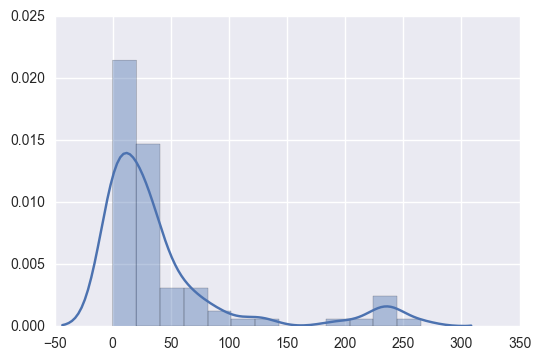

In [73]:
missing = (df.isnull().sum()).sort_values(ascending=False)
print missing
sns.distplot(missing)


In [75]:
x = df.iloc[:,4:]
y = df['Oxidable'].apply(lambda x: x == 'Yes')
print pd.DataFrame(x.columns).head()
print x.head()
print y.head()

          0
0  Yd.chain
1  Fd.chain
2  Wd.chain
3  nY.chain
4  nF.chain
   Yd.chain  Fd.chain  Wd.chain  nY.chain  nF.chain  nW.chain  \
0      10.6       4.8       8.6         0         2         0   
1      10.9       8.8      12.6         0         0         0   
2       8.3      11.6      14.2         0         0         0   
3       6.8       4.8       9.2         1         1         0   
4       9.8       5.8      10.5         0         1         0   

   numberBonds.chain  closestAro.chain  Yd.pdb  Fd.pdb  ...   CT_M  CT_N  \
0                  2               4.8    10.6     4.8  ...   22.0  37.0   
1                  0               8.8    10.9     8.8  ...   22.0  15.0   
2                  0               8.3     8.3    11.6  ...   55.0   6.0   
3                  2               4.8     6.8     4.8  ...   12.0  30.0   
4                  1               5.8     9.8     5.8  ...   25.0  18.0   

   CT_P  CT_Q  CT_R  CT_S  CT_T  CT_V   CT_W  CT_Y  
0  38.0   2.0  14.0  27.0  

In [76]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import scipy



classifier = Pipeline([
        ('imputer', Imputer(strategy='mean')),
        ('rf', RandomForestClassifier(n_estimators=1000, class_weight='balanced'))
    ])

from sklearn.metrics import matthews_corrcoef, make_scorer

scoring = {
    'accuracy': 'accuracy',
#     'precision_macro': 'precision_macro',
#     'recall_macro': 'recall_macro',
#     'f1':'f1',
    'f1_macro':'f1_macro',
    'f1_micro':'f1_micro',
    'mcc':make_scorer(matthews_corrcoef)
}

cv_results = cross_validate(classifier, x, y, cv=5, scoring=scoring, verbose=10, return_train_score=False )
pd.DataFrame(cv_results)

# print np.mean(scores), scipy.stats.norm.interval(0.95, loc=np.mean(scores), scale=np.std(scores))


[CV]  ................................................................
[CV]  , f1_macro=0.465940054496, mcc=0.0, f1_micro=0.872448979592, accuracy=0.872448979592, total=   4.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  , f1_macro=0.461538461538, mcc=-0.0476709626496, f1_micro=0.857142857143, accuracy=0.857142857143, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV]  , f1_macro=0.467213114754, mcc=0.0, f1_micro=0.876923076923, accuracy=0.876923076923, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s


[CV]  , f1_macro=0.465564738292, mcc=-0.0270459664935, f1_micro=0.871134020619, accuracy=0.871134020619, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.3s remaining:    0.0s


[CV]  , f1_macro=0.467032967033, mcc=0.0, f1_micro=0.876288659794, accuracy=0.876288659794, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.3s finished


,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_mcc
0,4.017,0.313,0.872449,0.465940,0.872449,0.000000
1,3.671,0.328,0.857143,0.461538,0.857143,-0.047671
2,3.689,0.343,0.876923,0.467213,0.876923,0.000000
3,3.689,0.309,0.871134,0.465565,0.871134,-0.027046
4,3.644,0.328,0.876289,0.467033,0.876289,0.000000


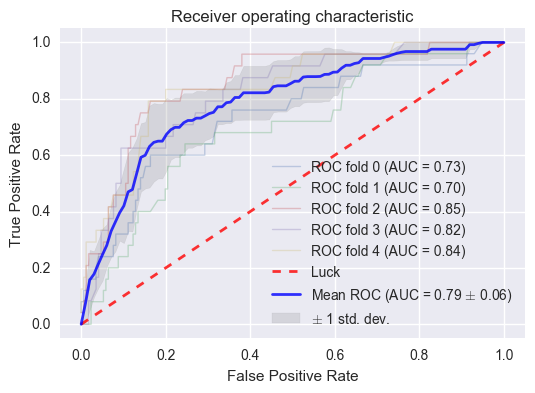

In [77]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

cv = StratifiedKFold(n_splits=5)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x, y):
    probas_ = classifier.fit(x.iloc[train], y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

    importance              name
17    0.069347          SASA.pdb
16    0.066137        SASA.chain
75    0.035022              CT_Y
46    0.027713              NT_M
30    0.025284             Met2Y
54    0.021758              NT_W
9     0.020024            Fd.pdb
15    0.019117    closestAro.pdb
22    0.019059           Bfactor
38    0.018905              NT_D
7     0.018027  closestAro.chain
50    0.017780              NT_R
42    0.017529              NT_H
1     0.017247          Fd.chain
31    0.017213         Met2S_PTM
62    0.016978              CT_H
0     0.016414          Yd.chain
23    0.016173               dpx
44    0.015666              NT_K
32    0.015533         Met2T_PTM


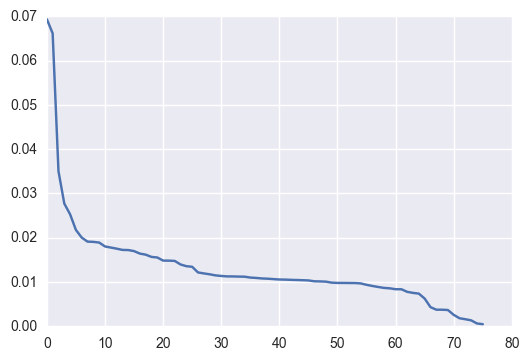

In [85]:

importance = pd.DataFrame({'name':x.columns, 'importance':classifier.steps[1][1].feature_importances_}).sort_values(by='importance',ascending=False)
print importance.head(20)
plt.plot(np.arange(0,len(importance)),importance['importance'])

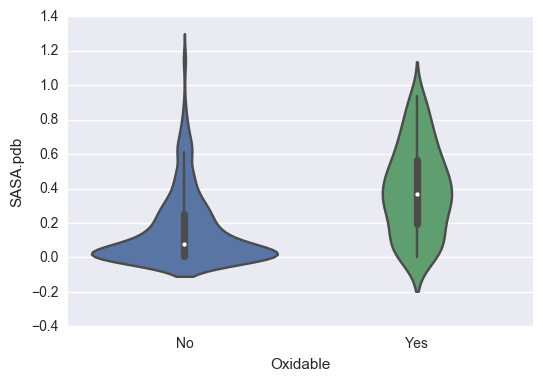

In [86]:
sns.violinplot(x=df['Oxidable'], y=df['SASA.pdb'])